In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
import xgboost as xgb

# loading the dataset
df = pd.read_csv(r"..\Data\Flight_Price.csv")

# removing null values
df = df.dropna()

# convert Date_of_Journey to day, month, year
df['Day'] = pd.to_datetime(df['Date_of_Journey'],format="%d/%m/%Y").dt.day
df['Month'] = pd.to_datetime(df['Date_of_Journey'],format="%d/%m/%Y").dt.month
df['Year'] = pd.to_datetime(df['Date_of_Journey'],format="%d/%m/%Y").dt.year

# split duration into hours and minutes
df['Duration_Hours'] = df['Duration'].str.extract(r'(\d+)h').fillna(0).astype(int)
df['Duration_Minutes'] = df['Duration'].str.extract(r'(\d+)m').fillna(0).astype(int)
df['Dep_Hour'] = df['Dep_Time'].str.split(":").str[0].astype(int)
df['Dep_Minute'] = df['Dep_Time'].str.split(":").str[1].astype(int)

# cleaning the arrival time using regular expression
df['clean_Arrival_Time'] = df['Arrival_Time'].str.extract(r"(\d{1,2}:\d{2})")
df['Arr_Hour'] = df['clean_Arrival_Time'].str.split(":").str[0].astype(int)
df['Arr_Minute'] = df['clean_Arrival_Time'].str.split(":").str[1].astype(int)

# encoding categrical data
df['Total_Stops'] = df['Total_Stops'].map({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4})
label_encoder = LabelEncoder()
df['Airline'] = label_encoder.fit_transform(df['Airline'])
df['Source'] = label_encoder.fit_transform(df['Source'])
df['Destination'] = label_encoder.fit_transform(df['Destination'])
df['Additional_Info'] = label_encoder.fit_transform(df['Additional_Info'])

# droping unnecessary columns
df.drop(['Route'],axis=1,inplace=True)
df.drop(['Date_of_Journey'],axis=1,inplace=True)
df.drop(['Duration'],axis=1,inplace=True)
df.drop(['Dep_Time'],axis=1,inplace=True)
df.drop(['Arrival_Time'],axis=1,inplace=True)
df.drop(['clean_Arrival_Time'],axis=1,inplace=True)

# defining independent variables (x) and targeted variable (y)
x = df.drop(columns=['Price'])
y = df['Price']

# spliting the data set into test,train data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
models = [LinearRegression(), Lasso(), Ridge(),RandomForestRegressor(n_estimators=200, random_state=42),
         xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
         ]
for model in models:
    model.fit(x_train,y_train)
    train_prediction = model.predict(x_train)
    test_prediction = model.predict(x_test)
    print(f"{type(model).__name__}")
    print("******Train******")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_train,train_prediction))}")
    print(f"mean squared error: {mean_squared_error(y_train,train_prediction)}")
    print(f"r2_score: {r2_score(y_train,train_prediction)}") 
    print("******Test******")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test,test_prediction))}")
    print(f"mean squared error: {mean_squared_error(y_test,test_prediction)}")
    print(f"r2_score: {r2_score(y_test,test_prediction)}")

LinearRegression
******Train******
RMSE: 3457.045178845118
mean squared error: 11951161.368576271
r2_score: 0.4359880982907075
******Test******
RMSE: 3480.844672135343
mean squared error: 12116279.631533004
r2_score: 0.4380740199646047
Lasso
******Train******
RMSE: 3457.046285603645
mean squared error: 11951169.020805959
r2_score: 0.435987737158556
******Test******
RMSE: 3480.9012576017963
mean squared error: 12116673.565173768
r2_score: 0.4380557502024428
Ridge
******Train******
RMSE: 3457.0453249164716
mean squared error: 11951162.378526833
r2_score: 0.4359880506280478
******Test******
RMSE: 3480.857249276678
mean squared error: 12116367.189842
r2_score: 0.43806995920584957
RandomForestRegressor
******Train******
RMSE: 629.4578174931003
mean squared error: 396217.14400317706
r2_score: 0.9813012996823355
******Test******
RMSE: 1754.1846424244807
mean squared error: 3077163.759717903
r2_score: 0.8572880195907044
XGBRegressor
******Train******
RMSE: 914.0929100419736
mean squared error:

In [2]:
import mlflow
import numpy as np
import mlflow.sklearn
from mlflow.models import infer_signature
models = [
    (
        "LinearRegression",
        {'fit_intercept':True},
        LinearRegression(),
        (x_train,y_train),
        (x_test,y_test)
    ),
    (
        "Lasso",
        {'alpha':0.1},
        Lasso(),
        (x_train,y_train),
        (x_test,y_test)
    ),
    (
        "Ridge",
        {'alpha':1.0, 'solver':'auto'},
        Ridge(),
        (x_train,y_train),
        (x_test,y_test)
    ),
    (
        "RandomForestRegressor",
        {'n_estimators':200, 'random_state':42, 'max_depth':5},
        RandomForestRegressor(),
        (x_train,y_train),
        (x_test,y_test)
    ),
    (
        "XGBRegressor",
        {'n_estimators':200, 'random_state':42, 'learning_rate':0.1},
        xgb.XGBRegressor(),
        (x_train,y_train),
        (x_test,y_test)
    )
]


In [3]:
reports = []
for model_name, params, model, train_set, test_set in models:
    x_train = train_set[0]
    y_train = train_set[1]
    x_test = test_set[0]
    y_test = test_set[1]
    # Apply hyperparameters and train the model
    model.set_params(**params)
    model.fit(x_train,y_train)
    y_prediction = model.predict(x_test)
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test,y_prediction))
    mse = mean_squared_error(y_test,y_prediction)
    r2score = r2_score(y_test,y_prediction)
    # storing results
    reports.append((model_name, rmse, mse, r2score))
reports

[('LinearRegression',
  3480.844672135343,
  12116279.631533004,
  0.4380740199646047),
 ('Lasso', 3480.850255136291, 12116318.498682382, 0.4380722173930506),
 ('Ridge', 3480.857249276678, 12116367.189842, 0.43806995920584957),
 ('RandomForestRegressor',
  2664.8549210024994,
  7101451.749991236,
  0.6706505333615345),
 ('XGBRegressor', 1665.2896562890637, 2773189.6393433483, 0.8713856339454651)]

In [5]:
import mlflow.xgboost
import webbrowser
# setting experiment 
mlflow.set_experiment("bus_price_prediction")

# giving tracking url
mlflow.set_tracking_uri("http://127.0.0.1:5000")
for i, element in enumerate(models):
    model_name = element[0]
    params = element[1]
    model = element[2]
    report = reports[i]
    with mlflow.start_run(run_name = model_name):
        mlflow.log_params(params)
        mlflow.log_metrics({'RMSE':report[1],
                            'MSE':report[2],
                            'r2_score':report[3]
                           })
        if "XGB" in model_name:
            mlflow.xgboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")

2025/02/05 22:30:38 INFO mlflow.tracking.fluent: Experiment with name 'bus_price_prediction' does not exist. Creating a new experiment.
2025/02/05 22:31:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression at: http://127.0.0.1:5000/#/experiments/230542027533444038/runs/cd5ca40cabc64079aa7e44bb40ee160d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/230542027533444038


2025/02/05 22:31:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso at: http://127.0.0.1:5000/#/experiments/230542027533444038/runs/c6bc231291074098a0570d624aa80f09
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/230542027533444038


2025/02/05 22:31:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge at: http://127.0.0.1:5000/#/experiments/230542027533444038/runs/9157b205c6324061a11aa8e1e27d4ae6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/230542027533444038


2025/02/05 22:31:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestRegressor at: http://127.0.0.1:5000/#/experiments/230542027533444038/runs/305ad238e7124b07b9229b0cd75d105a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/230542027533444038


C:\Users\vmami\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/02/05 22:31:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBRegressor at: http://127.0.0.1:5000/#/experiments/230542027533444038/runs/ad62d0b23e344ae8acb6288af375fb66
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/230542027533444038


In [6]:
reports

[]

In [6]:
df

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Day,Month,Year,Duration_Hours,Duration_Minutes,Dep_Hour,Dep_Minute,Arr_Hour,Arr_Minute
0,3,0,5,0,8,3897,24,3,2019,2,50,22,20,1,10
1,1,3,0,2,8,7662,1,5,2019,7,25,5,50,13,15
2,4,2,1,2,8,13882,9,6,2019,19,0,9,25,4,25
3,3,3,0,1,8,6218,12,5,2019,5,25,18,5,23,30
4,3,0,5,1,8,13302,1,3,2019,4,45,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0,3,0,0,8,4107,9,4,2019,2,30,19,55,22,25
10679,1,3,0,0,8,4145,27,4,2019,2,35,20,45,23,20
10680,4,0,2,0,8,7229,27,4,2019,3,0,8,20,11,20
10681,10,0,5,0,8,12648,1,3,2019,2,40,11,30,14,10


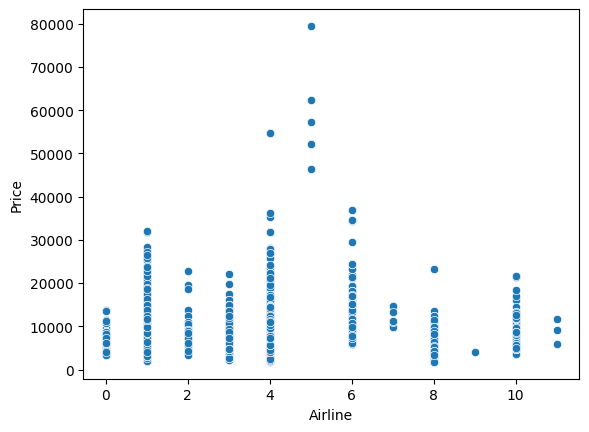

In [9]:
# Exploratory Data Analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot
sns.scatterplot(df, x="Airline", y = "Price")
plt.show()

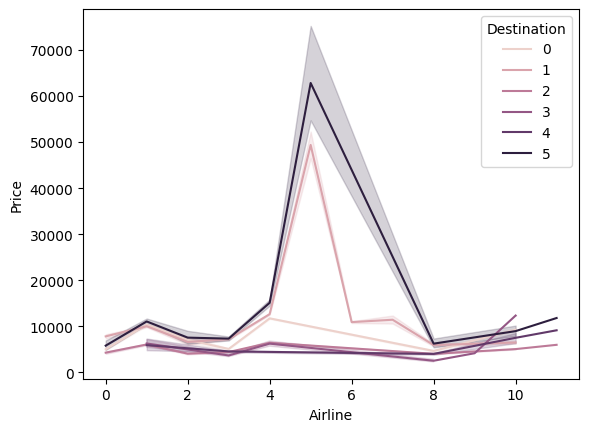

In [10]:
# line plot

sns.lineplot(df, x="Airline", y = "Price", hue = "Destination")
plt.show()

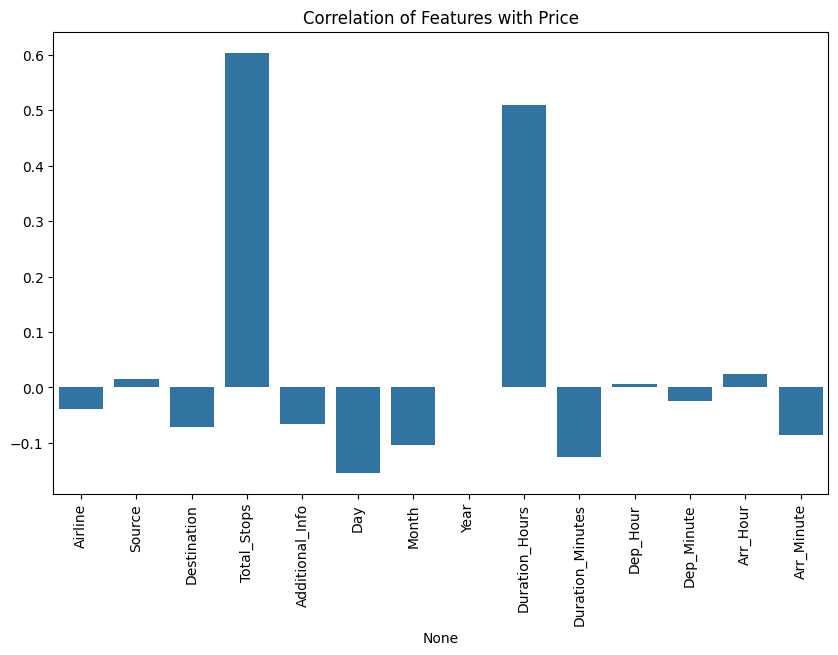

In [14]:
# bar chart

# Calculate correlation with 'Price'
correlation = df.corr()['Price'].drop('Price')

# Create a barplot of correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.index, y=correlation.values)
plt.title('Correlation of Features with Price')
plt.xticks(rotation=90)
plt.show()

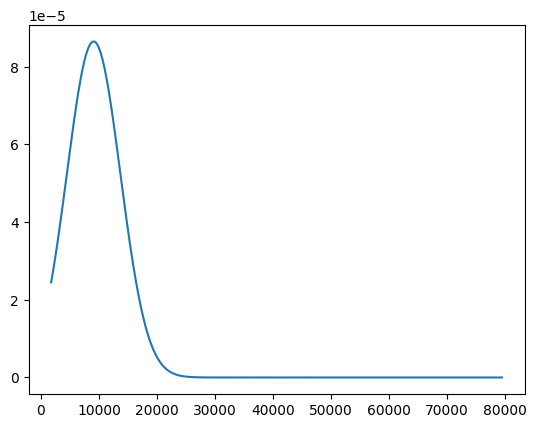

In [17]:
# probability density function
from scipy.stats import norm
mean = df['Price'].mean()
std = df['Price'].std()
price = np.sort(df['Price'])
pdf = norm.pdf(price,mean,std)
plt.plot(price,pdf)
plt.show()

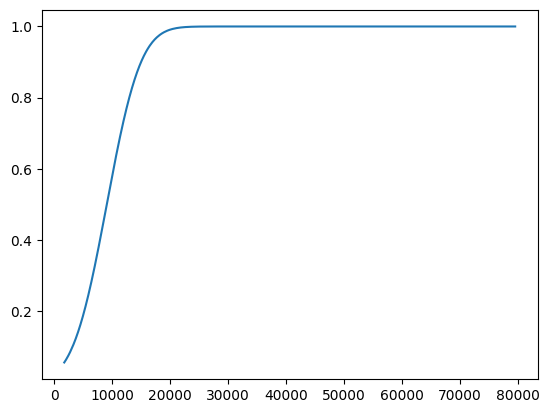

In [19]:
mean = df['Price'].mean()
std = df['Price'].std()
price = np.sort(df['Price'])
cdf = norm.cdf(price,mean,std)
plt.plot(price,cdf)
plt.show()

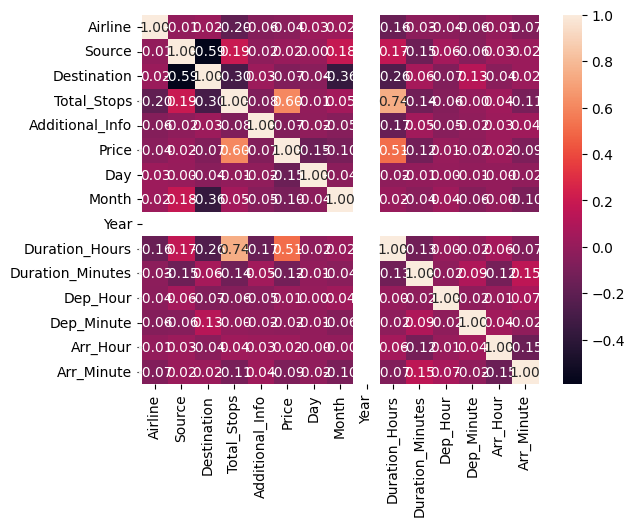

In [20]:
# heat map
corr = df.corr()
sns.heatmap(corr,fmt=".2f",annot = True)
plt.show()